# **1. Obtener de cada modelo:** Resultados, tiempo de ejecución, parámetros y CO2

In [1]:
# Importar pandas
from src.experiments.Common import load_best_model
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

baselines_path = "models/Baselines"

datasets = {"restaurants":["gijon", "barcelona", "madrid", "paris", "newyorkcity"],
            "pois":["barcelona", "madrid", "paris", "newyorkcity", "london"],
            "amazon":["fashion", "digital_music"]}

our_model="ETeR-X"

set_names = {"Amazon":"AM", "Pois":"POI", "Restaurants":"RST"}
subset_names = {"Digital_Music":"MSC", "Music":"MSC", "Fashion":"FSH", "Gijon":"GJN", "Gijón":"GJN", "Barcelona":"BCN", "Madrid":"MDR", "Newyorkcity":"NYC", "New York":"NYC", "Paris":"PRS", "London":"LND"}

models_cold = {"MOSTPOP2ITM":"MostPop", "BOW2ITM":our_model, "USEM2ITM":"USEM", "BERT2ITM":"BERT"}
models_baseline = {'BiVAECF':"BiVAE", 'EASEᴿ':"EASEᴿ", **models_cold}

model_colors = {'BiVAE':"#FF708F", 'EASEᴿ':"#95ABB2", 'MostPop':'#AD858B', our_model:'#4CAF50', 'USEM':'#03A9F4', 'BERT':'#ffa726'}


2024-06-04 12:21:05.644468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:21:05.644572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:21:05.809455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 12:21:06.151316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:21:08.456720: W tensorflow/compiler/tf2

Using TensorFlow backend


In [2]:
def extract_baseline_data(path, dataset, subset):
    
    def process_section(lines):
        # Obtener las columnas
        columns = lines[1].split("|")
        columns = [col.strip() for col in columns]
        
        # Obtener los datos
        data = []
        for line in lines[3:]:
            if line.strip() == '':
                continue
            row = line.split("|")
            row = [item.strip() for item in row]
            data.append(row)
        
        # Crear el DataFrame
        df = pd.DataFrame(data, columns=columns)
        return df

    # Obtener el fichero con los tiempos
    paths = sorted(Path(path).iterdir(), key=os.path.getmtime)
    filepath = [str(f) for f in paths if "CornacExp" in f.name][-1]

    # Leer el archivo
    with open(filepath, 'r') as file: lines = file.readlines()

    # Separar las secciones
    validation_start = lines.index('VALIDATION:\n')
    test_start = lines.index('TEST:\n')

    validation_lines = lines[validation_start + 1:test_start]
    test_lines = lines[test_start + 1:]

    # Procesar cada sección
    validation_df = process_section(validation_lines)
    test_df = process_section(test_lines)
    
    test_df.rename(columns={"":"Model", "Train (s)":"Train_time"}, inplace=True)
    
    model_paper_names = {"GridSearch_EASEᴿ":"EASEᴿ", "GridSearch_BPR":"BPR", "online_ibpr": "IBPR"}
    
    # Obtener los resultados en test de todos los modelos 
    all_test_results = pd.read_csv(path+"results.csv").reset_index(drop=True)
    all_test_results = all_test_results.merge(test_df[["Model", "Train_time"]], on="Model", how="left")
    all_test_results["Model"] = all_test_results["Model"].apply(lambda x: model_paper_names[x] if x in model_paper_names.keys() else x)
    
    all_test_results.insert(0, "Subset", subset)
    all_test_results.insert(0, "Set", dataset)
    return all_test_results

def evaluate_cold_start(model_class):
    # Eliminar usuarios que aparecen en TRAIN
    train_dev_users = model_class.DATASET.DATA["TRAIN_DEV"].userId.unique()
    # original_test_len = len(model_class.DATASET.DATA["TEST"])
    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"][~model_class.DATASET.DATA["TEST"]["userId"].isin(train_dev_users)]
    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"].drop_duplicates(subset=["userId", "id_item"], keep='last', inplace=False)
    # Evaluar en el conjunto de test
    test_ret = model_class.train(dev=False, save_model=True)
    # Evaluar en el conjunto de test
    test_ret = model_class.evaluate(test=True, verbose=False)
    return test_ret.to_dict(orient="records")[0]

In [3]:
if not os.path.exists("models/all_baseline_data.xlsx") and not os.path.exists("models/all_cold_start_data.xlsx"):

    all_baseline_data = []
    all_cold_start_data = []

    for dataset, subsets in datasets.items():
        for subset in subsets:
            # Definir el nombre del fichero
            base_path = "/media/nas/pperez/code/TAVtext/"
            path = f"{base_path}{baselines_path}/{dataset}/{subset}/"
            # Extraer todos los datos de los baselines
            baseline_data = extract_baseline_data(path, dataset=set_names[dataset.title()], subset=subset_names[subset.title()])
            # Cambiamos los nombres
            baseline_data["Model"] = baseline_data["Model"].apply(lambda x: models_baseline[x] if x in models_baseline.keys() else x)
            # Eliminamos modelos irrelevantes 
            baseline_data = baseline_data[baseline_data["Model"].isin(list(models_baseline.values()))]
            # Para los modelos no baseline, hacer lo mismo
            cold_start_data = []
            for model in list(models_cold.keys()):
                # Cargar mejor modelo
                model_class = load_best_model(model=model, dataset=dataset, subset=subset, base_path=base_path)
                # Obtener los resultados en cold_start
                metrics = evaluate_cold_start(model_class)
                # Obtener el número de parámetros
                params = model_class.MODEL.count_params()
                # Obtener el tiempo de train
                time = pd.read_csv(model_class.MODEL_PATH+"log.csv")["e_time"].sum()
                # Obtener emisiones
                emissions = pd.read_csv(model_class.MODEL_PATH+"emissions_train.csv").drop_duplicates("project_name")
                emissions = emissions["emissions"].sum()
                # Añadir a baselines
                baseline_data.loc[baseline_data["Model"]==models_cold[model], "Train_time"] = time
                baseline_data.loc[baseline_data["Model"]==models_cold[model], "Params"] = params
                baseline_data.loc[baseline_data["Model"]==models_cold[model], "co2"] = emissions
                # Añadir a cold_start
                cold_start_data.append({"Set":set_names[dataset.title()], "Subset":subset_names[subset.title()], "Model": models_cold[model], "Train_time": time, "Params":params, "co2": emissions, **metrics})
                    
            # Añadir a los correspondientes datasets finales
            all_baseline_data.extend(baseline_data.to_dict(orient='records'))
            all_cold_start_data.extend(cold_start_data)

    all_baseline_data = pd.DataFrame(all_baseline_data)
    all_cold_start_data = pd.DataFrame(all_cold_start_data)

    # Guardamos los resultados dado que es temporalmente costoso recalcularlos
    all_baseline_data.to_excel("models/all_baseline_data.xlsx", index=False)
    all_cold_start_data.to_excel("models/all_cold_start_data.xlsx", index=False)

else:
    # Guardamos los resultados dado que es temporalmente costoso recalcularlos
    all_baseline_data = pd.read_excel("models/all_baseline_data.xlsx")
    all_cold_start_data = pd.read_excel("models/all_cold_start_data.xlsx")
    
# Determinamos el orden deseado
all_baseline_data["Set"] = pd.Categorical(all_baseline_data["Set"], list(set_names.values()))
all_cold_start_data["Set"] = pd.Categorical(all_cold_start_data["Set"], list(set_names.values()))

all_baseline_data["Subset"] = pd.Categorical(all_baseline_data["Subset"], list(dict.fromkeys(subset_names.values())))
all_cold_start_data["Subset"] = pd.Categorical(all_cold_start_data["Subset"], list(dict.fromkeys(subset_names.values())))

all_baseline_data["Model"] = pd.Categorical(all_baseline_data["Model"], list(models_baseline.values()))
all_cold_start_data["Model"] = pd.Categorical(all_cold_start_data["Model"], list(models_cold.values()))

### Exportar los resultados de los experimentos

In [4]:
bl_results = all_baseline_data.melt(id_vars=['Set', 'Subset', 'Model'], value_vars=['NDCG@10', 'Recall@10'], var_name='Metric', value_name='Value')
bl_results = bl_results.pivot_table(index=['Set', 'Subset', 'Metric'], columns='Model', values='Value')
bl_results.to_excel("output/baselines_results.xlsx")

In [5]:
cs_results = all_cold_start_data.melt(id_vars=['Set', 'Subset', 'Model'], value_vars=['NDCG@10', 'Recall@10'], var_name='Metric', value_name='Value')
cs_results = cs_results.pivot_table(index=['Set', 'Subset', 'Metric'], columns='Model', values='Value')
cs_results.to_excel("output/cold_start_results.xlsx")

### Crear tablas con información unica de parametros y tiempos

In [6]:
time_results = all_baseline_data[all_baseline_data['Train_time'].notna()].pivot_table(index=["Set", "Subset"], columns=["Model"], values=["Train_time"])
param_results = all_cold_start_data.pivot_table(index=["Set", "Subset"], columns=["Model"], values=["Params"])

time_results.to_excel("output/time_results.xlsx")
param_results.to_excel("output/param_results.xlsx")

# 2. Generar gráficos para el artículo

In [ ]:
def bar_plot_comparison(data, column_name="co2", title="Total train emissions (gr)", share_y=False, ylim=None, legend=True, y_scale="linear"):
    # Ordenar por modelos
    data = data.sort_values("Model")
    # Calcular el número de elementos en X para cada dataset
    num_elements = data[["Set", "Subset"]].drop_duplicates().groupby("Set", sort=False)["Subset"].size().values.tolist()
    sets = data["Set"].unique()
    models = data["Model"].unique()

    # Normalizar los anchos de los subplots para que el total sea 1
    total_elements = sum(num_elements)
    relative_widths = [n / total_elements for n in num_elements]

    # Crear una figura con subplots horizontales y anchos personalizados
    fig, axes = plt.subplots(1, len(sets), figsize=(sum(num_elements) * .65+2, 2.8), gridspec_kw={'width_ratios': relative_widths}, sharey=share_y)

    # Iterar sobre los datasets y sus correspondientes ejes
    for plot_idx, (dataset, ax) in enumerate(zip(sets, axes)):
        X = data[data["Set"]==dataset]["Subset"].unique().tolist()
        model_values = data[data["Set"]==dataset].groupby("Model", sort=False).apply(lambda x: x[column_name].values.tolist()).to_frame().to_dict()[0]

        X_axis = np.arange(len(X))
        
        bar_width = 0.7 / len(model_values)  # Ajustar el ancho de las barras
        offset = 0  # Inicializar el desplazamiento
        margin = 0.02
        # model_names = {"BOW2ITM":"TeRCEx", "USEM2ITM":"USEM", "BERT2ITM":"BERT"}
        
        for i, (model, values) in enumerate(model_values.items()):
            color = model_colors[model] # model_colors[i % len(model_colors)]  # Seleccionar un color de la lista en función de la posición del modelo
            try:
                ax.bar(X_axis + offset - margin, values, bar_width-margin, label=model, color=color)
            except:
                print(model, values, color, dataset)
            offset += bar_width  # Incrementar el desplazamiento para el próximo modelo

        ax.set_xticks(X_axis + bar_width * (len(model_values) - 1) / 2)
        ax.set_xticklabels(X)  # Ajustar las etiquetas del eje X

        # if plot_idx == 0: ax.set_ylabel(axis_label)
        if share_y and ylim is not None: ax.set_ylim(ylim)
        ax.set_title(dataset)
        ax.set_axisbelow(True)
        ax.grid(axis="y")
        ax.set_yscale(y_scale)
    
    # Mostrar la leyenda solo una vez
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(models))

    # Ajustar el layout para que no se solapen los subplots
    # plt.title(dataset)
    fig.suptitle(title, fontsize=15, fontweight="bold", y=0.95)
    plt.tight_layout()

    plt.savefig(f"output/bar_plot_{column_name}.pdf",bbox_inches='tight')
    plt.show()
    
    return fig

bar_plot_comparison(all_baseline_data, column_name="Train_time", y_scale="log", share_y=True, title="Training time (s)")

# Eliminamos el MostPop, para estos gráficos, no aportan mucho
cold_no_pop = all_cold_start_data.loc[all_cold_start_data["Model"]!="MostPop"].reset_index(drop=True)
cold_no_pop["Model"] = pd.Categorical(cold_no_pop["Model"], ['ETeR-X', 'USEM', 'BERT'])

fig1 = bar_plot_comparison(cold_no_pop, column_name="co2", y_scale="log", share_y=True, title="Train emissions (g of CO2)")
fig2 = bar_plot_comparison(cold_no_pop, column_name="Params", y_scale="log", share_y=True, title="Model parameters")

### Version del anterior que permite apilar varias figuras

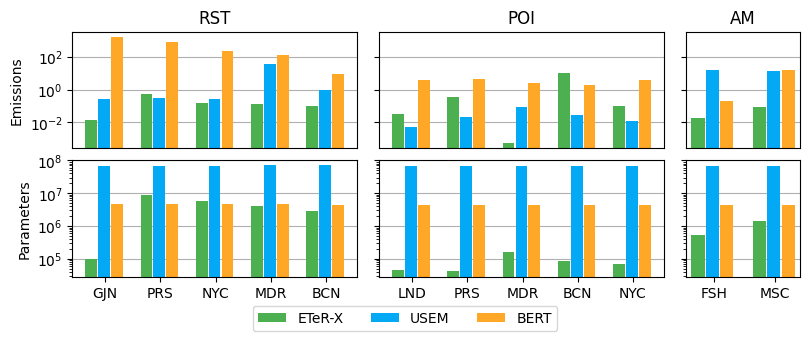

In [127]:
def bar_plot_comparison(data, axes, column_name="co2", title="Total train emissions (gr)", share_y=False, ylim=None, legend=True, show_title=True, show_x_labels=True, y_scale="linear"):
    # Ordenar por modelos
    data = data.sort_values("Model")
    # Calcular el número de elementos en X para cada dataset
    num_elements = data[["Set", "Subset"]].drop_duplicates().groupby("Set", sort=False)["Subset"].size().values.tolist()
    sets = data["Set"].unique()
    models = data["Model"].unique()

    # Normalizar los anchos de los subplots para que el total sea 1
    total_elements = sum(num_elements)
    relative_widths = [n / total_elements for n in num_elements]

    # Iterar sobre los datasets y sus correspondientes ejes
    for plot_idx, (dataset, ax) in enumerate(zip(sets, axes.flatten())):
        X = data[data["Set"]==dataset]["Subset"].unique().tolist()
        model_values = data[data["Set"]==dataset].groupby("Model", sort=False).apply(lambda x: x[column_name].values.tolist()).to_frame().to_dict()[0]

        X_axis = np.arange(len(X))
        
        bar_width = 0.7 / len(model_values)  # Ajustar el ancho de las barras
        offset = 0  # Inicializar el desplazamiento
        margin = 0.02
        
        for i, (model, values) in enumerate(model_values.items()):
            color = model_colors[model]
            try:
                ax.bar(X_axis + offset - margin, values, bar_width-margin, label=model, color=color)
            except:
                print(model, values, color, dataset)
            offset += bar_width  # Incrementar el desplazamiento para el próximo modelo

        if show_x_labels:
            ax.set_xticks(X_axis + bar_width * (len(model_values) - 1) / 2)
            ax.set_xticklabels(X)  # Ajustar las etiquetas del eje X
        else:
            ax.set_xticks([])
        
        if plot_idx==0: ax.set_ylabel(title)

        if share_y and ylim is not None: ax.set_ylim(ylim)
        if show_title: ax.set_title(dataset)
        ax.set_axisbelow(True)
        ax.grid(axis="y")
        ax.set_yscale(y_scale)
    
    return ax

data = cold_no_pop
num_elements = data[["Set", "Subset"]].drop_duplicates().groupby("Set", sort=False)["Subset"].size().values.tolist()
sets = data["Set"].unique()
models = data["Model"].unique()

# Normalizar los anchos de los subplots para que el total sea 1
total_elements = sum(num_elements)
relative_widths = [n / total_elements for n in num_elements]

fig, ax = plt.subplots(2, 3, figsize=(sum(num_elements) * .6+1, 3.5), gridspec_kw={'width_ratios': relative_widths}, sharey='row')

bar_plot_comparison(cold_no_pop, ax[0,:], column_name="co2", y_scale="log", share_y=True, show_x_labels=False, title="Emissions")
bar_plot_comparison(cold_no_pop, ax[1,:], column_name="Params", y_scale="log", share_y=True, show_title=False, title="Parameters")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.025), ncol=3)

plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.15)

plt.savefig(f"output/bar_plot_co2_params.pdf",bbox_inches='tight')

plt.show()

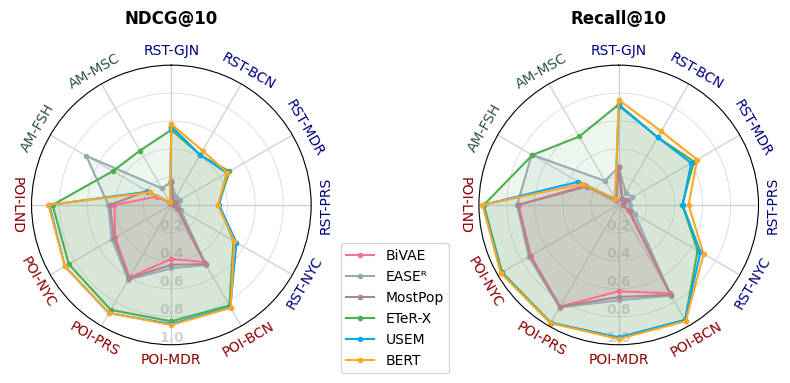

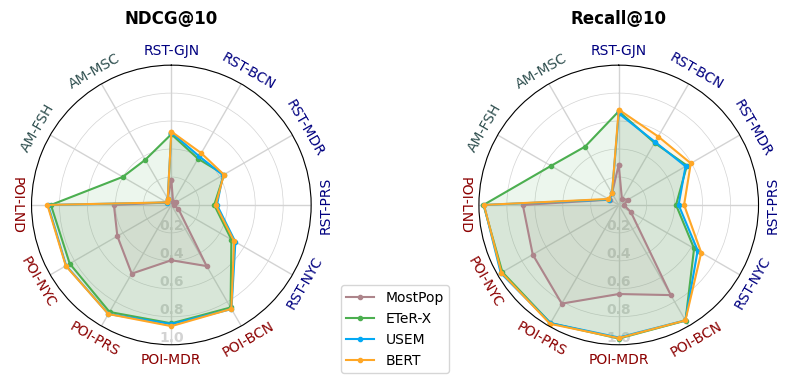

In [8]:
def polar_plot_comparison(data, metrics=["NDCG@10", "Recall@10"], output_file="polar_plot.pdf"):
    
    def cerrar_ciclo(data):
        return np.append(data, data[0])
    
    def plot_radial_data(axis, models, datasets, plot_data, column, title="Title", max_y=None, fmt='{:.3f}'):
        axis.set_theta_zero_location("N")
        axis.set_theta_direction(-1)

        for idx, modelo in enumerate(models):
            values = plot_data.loc[plot_data["Model"] == modelo][column].values
            values = np.append(values, values[0])
            theta = np.linspace(0, 2 * np.pi, len(values), endpoint=True)
            color = model_colors[modelo]  # Seleccionar un color de la lista en función de la posición del modelo
            axis.fill(theta, values, alpha=0.1, color=color)
            axis.plot(theta, values, label=modelo, marker=".",  color=color)
        axis.set_title(title, pad=30, fontweight="bold")
        
        if max_y is not None: axis.set_ylim(0, max_y)
        axis.yaxis.set_major_locator(FixedLocator(axis.get_yticks()))
        axis.set_yticklabels([fmt.format(tick) for tick in axis.get_yticks()], ha='center', va='bottom', color='lightgrey', fontweight='bold')
        axis.set_axisbelow(True)
        # Get radial labels away from plotted line
        axis.set_rlabel_position(180)  
        axis.set_xticks(np.linspace(0, 2*np.pi, len(datasets), endpoint=False))
        axis.set_xticklabels(datasets, fontsize=10)
        # Adjust grid colors and style
        axis.grid(linewidth=1, linestyle = '-', color="lightgrey")
        axis.yaxis.grid(linewidth=0.5, color="lightgrey")
        # Adjust datasets labels, rotation, color, ...
        angles = np.linspace(0, -2*np.pi, len(axis.get_xticklabels()) + 1)
        angles = np.rad2deg(angles[:-1])
        labels = []
        for label, angle in zip(axis.get_xticklabels(), angles):
            x, y = label.get_position()
            dataset_text = label.get_text()
            dataset_color = "darkred" if "POI" in dataset_text else "navy" if "RST" in dataset_text else "darkslategray"
            # Ajustar la posición de las etiquetas y rotarlas para que formen 90 grados con el radio
            if angle <= -90 and angle >= -270: rotation_angle = angle  - 180
            else: rotation_angle = angle
            lab = axis.text(x, y + 0.035, dataset_text, transform=label.get_transform(), ha='center', va='center', rotation=rotation_angle, color=dataset_color)
            labels.append(lab)
        axis.set_xticklabels([])

    # Lista de modelos
    modelos = list(data["Model"].sort_values().unique())
    # Crear una lista de sets+subsets como títulos
    datasets = data[["Set", "Subset"]].drop_duplicates().apply(lambda x: x["Set"]+"-"+x["Subset"], axis=1).values.tolist()
    # Contar sets y subsets
    n_datasets = len(datasets)
    # Crear los dos gráficos radiales (polar plots)
    fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(8,5))
    axs = axs.flatten()
    
    for id_plot, metric in enumerate(metrics):
        plot_radial_data(axs[id_plot], modelos, datasets, data, fmt='{:.1f}',max_y=1, column=metric, title=metric)
        
    # Añadir una sola leyenda en el centro abajo
    lines, labels = axs[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.15), ncol=1)
    # Ajustar el espacio horizontal entre los gráficos
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.6, hspace=0, top=0.85, bottom=0.15)
    # Guardar figura
    plt.savefig("output/"+output_file, bbox_inches='tight')
    plt.show()

polar_plot_comparison(all_baseline_data, metrics=["NDCG@10", "Recall@10"], output_file="baseline_polar_plot.pdf")
polar_plot_comparison(all_cold_start_data, metrics=["NDCG@10", "Recall@10"], output_file="cold_start_polar_plot.pdf")